# Internet of Things (2IMN25)
### Machine Learning Assignment

### Introduction

The objective of the assignment is to use supervised machine learning techniques to make predictions about the net energy consumed based on the weather conditions. This will be accomplished by training a regression model on (real) data obtained from the weather sensor and energy meter over this year. This model will then be used to make predictions about the net energy consumption for data-points not *seen* by the model during training.

In [212]:
""" Import all libraries here """
import numpy as np
import os
import math
from datetime import datetime
import pandas as pd
from dateutil import parser
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

## Reading the dataset

In the code box below, please read in the data-sets into suitable data structures. The key task here would be to contruct the feature vectors which would be fed to the regression algorithm.

The datasets for the weather, rain and energy consumption have been provided in the zip file, extract this zip file into the same folder as the python notebook. The function should read both the weather and rainfall datafiles and create a merged feature vector array based on time-stamps.



In [213]:
def merge_weather_rain_data(data_path): # Select month for which data is collected
    """ 
    Reads in the CSV files for weather and rain data
    Merged them into a single array based on matching time-stamps
    
    """
        
    """ Read in the weather"""
    weatherFrame = pd.read_csv(os.path.join(data_path,'Weather-Eindhoven.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0],
                             usecols = [0,1,2,4,6,7,8]) #Drop "chill", too many missing values
    weather_array  = weatherFrame.as_matrix()

    """ Read in the rain data"""
    rainFrame = pd.read_csv(os.path.join(data_path,'Rain-Best.csv'),
                             delimiter = ',',
                             header =  None,
                             skiprows = 1,
                             index_col = None,
                             parse_dates = [0]
                            )
    rain_array = rainFrame.as_matrix()

    """ Synchronize the 2 data-sets by removing the extra data from the rainfall dataset"""
    remove_rows = []
    for element,idx in zip(rain_array[:,0],range(len(rain_array[:,0]))):
        if element.minute%10 != 0:
            remove_rows.append(idx)

    synced_rain_array = np.delete(rain_array,remove_rows,axis = 0)

    print(synced_rain_array.shape)
    print(weather_array[:,0].shape)

    """ Merge the weather and rain data when time-stamps are equal """
    merged_array = []
    for rainElem in synced_rain_array:
        try :
            merged_row = []
            valid_row = list(weather_array[:,0]).index(rainElem[0])
            for weatherFeature in weather_array[valid_row]:
                merged_row.append(weatherFeature)
            merged_row.append(rainElem[1])
            merged_row.append(weather_array[valid_row][0].hour) # Add "time of day" information 
            merged_array.append(np.asarray(merged_row))
        except ValueError:
            print('Did not find matching timestamp in the weather data, continuing')
            continue

    merged_array = np.asarray(merged_array)
    return merged_array

# Create the merged array
data_path = os.path.join(os.getcwd(),'data')
merged_array = merge_weather_rain_data(data_path)

(43844, 2)
(43872,)
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matchin

## Cleaning the data

The datafiles may contain missing entries, in such an event, it is needed to get rid of such datapoints. The function should take in the created feature vector array and delete rows if features are missing.


In [214]:

def clean_up(merged_array):
    """ 
    Clean up the data by removing rows with missing data points 
    
    """
    missing_data_rows = []
    for row,idx in zip(merged_array,range(merged_array.shape[0])):
        for elem in row[1:]: #Timestamp,Description cannot be "checked"
            if pd.isnull(elem):
                missing_data_rows.append(idx)
                break # To prevent the same row from being added multiple times to the list, break when the first "nan" is found
    clean_data_array = np.delete(merged_array,missing_data_rows,axis=0)
    return clean_data_array

def filter_by_month(data_array,month):
    """
    Filter weather data by month
    
    """
    rows_delete = []
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if row[0].month != month:
            rows_delete.append(idx)
    filtered_array = np.delete(data_array,rows_delete,axis=0)
    return filtered_array

clean_data_array = clean_up(merged_array)
month_array = filter_by_month(clean_data_array,month = 7)

## Reading in the energy values

The aim of the assignment is to predict the solar energy produced based on the weather conditions. Thus, for each weather datapoint, the solar energy must be calclulated using the energy datafiles and matching the time-stamps. Define a function that first creates a single datastructure from all the different energy files. Then, design a function that can perform an energy look-up based on the time-stamp of the weather data. This fucntion should return the total solar energy produced between the previous timestamp and current timestamp.Using this look-up function, loop over all the time-stamps of the weather data and generate energy labels. It should be noted, that for certain time-stamps, the energy values might be missing, datapoints corresponding to such timestamps must be deleted from the data array. 

*Hint : Check the documentation for the python package pandas to design a fast lookup function*

In [215]:
def create_dataframe(energyDir):
    """ 
    Returns a dataframe that is formed by concatenating all the energy data files 
    """
    fileList = []
    energyDir = os.path.join(os.getcwd(),energyDir)
    dirList = [os.path.join(energyDir, o) for o in os.listdir(energyDir) 
                    if os.path.isdir(os.path.join(energyDir,o))]
    
    sortedDirList = sorted(dirList)
    for direc in sortedDirList:
        dirFiles = [os.path.join(direc, f) for f in os.listdir(direc) 
                    if os.path.isfile(os.path.join(direc,f))]
        for f in dirFiles:
            fileList.append(f)
        
    fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame
    
def energy_frame_month(energyDir,month):
    """
    Create an energy frame for only one month
    
    """
    energyDir = os.path.join(os.getcwd(),energyDir)
    if month < 10:
        monthDir = os.path.join(energyDir,'0{}'.format(month))
    else:
        monthDir = os.path.join(energyDir,'{}'.format(month))
        
    dirFiles = [os.path.join(monthDir, f) for f in os.listdir(monthDir) 
                    if os.path.isfile(os.path.join(monthDir,f))]
    fileList = []
    for f in dirFiles:
        fileList.append(f)
        fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame

    

    
energyFrame = energy_frame_month('data/2017',month = 7)
print(energyFrame)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


               TimeStamp  Energy Consumed  Energy Produced  \
0    2017-07-01 00:00:01              860                0   
1    2017-07-01 00:00:11             1030                0   
2    2017-07-01 00:00:21             1020                0   
3    2017-07-01 00:00:31             1110                0   
4    2017-07-01 00:00:41             1010                0   
5    2017-07-01 00:00:51              880                0   
6    2017-07-01 00:01:01             1000                0   
7    2017-07-01 00:01:11              880                0   
8    2017-07-01 00:01:21             1010                0   
9    2017-07-01 00:01:31             1010                0   
10   2017-07-01 00:01:41              880                0   
11   2017-07-01 00:01:51             1020                0   
12   2017-07-01 00:02:01              880                0   
13   2017-07-01 00:02:11              990                0   
14   2017-07-01 00:02:21              870                0   
15   201

In [216]:
def energy_lookup(data_array,energyFrame,idx):
    """ 
    Given the index, calculated the net-energy consumed in the 10-minute interval preceeding current time
    
    """
    try:
        subFrame = energyFrame[(energyFrame['TimeStamp']>data_array[idx-1][0]) & (energyFrame['TimeStamp']<data_array[idx][0])]
        if subFrame.shape[0] == 0:
            return None,None
        energyList = []
        solarList = []
        for cons,prod,solar in zip(subFrame['Energy Consumed'],subFrame['Energy Produced'],subFrame['Solar Energy Produced']):
            energyList.append(cons-prod)
            solarList.append(solar)
        return np.sum(np.asarray(energyList)),np.sum(np.asarray(solar))
    except:
        return None,None

def create_labels(data_array,energyFrame):
    """
    Uses the look-up function to create labels (if possible)
    for every feature vector in the feature array.
    
    """
    
    missing_labels = []
    labels = []
    labels_solar = []
    labels.append(0)
    labels_solar.append(0)
    energyFrame['TimeStamp'] = pd.to_datetime(energyFrame['TimeStamp']) 
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if idx == 0:
            continue
        netEnergy,netSolar = energy_lookup(data_array,energyFrame,idx)
        if netEnergy is None and netSolar is None:
            print('Missing label for row {}'.format(idx))
            missing_labels.append(idx)
        else:
            print('{} {} {}'.format(row[0],netEnergy,netSolar))
            labels.append(netEnergy)
            labels_solar.append(netSolar)
    return labels,labels_solar,missing_labels

labels,labels_solar,missing_labels = create_labels(month_array,energyFrame)
featureArray = np.delete(month_array,missing_labels,axis=0)
            

2017-07-01 00:10:00 55550 0
2017-07-01 00:20:00 51920 0
2017-07-01 00:30:00 76330 0
2017-07-01 00:40:00 47950 0
2017-07-01 00:50:00 46520 0
2017-07-01 01:00:00 46610 0
2017-07-01 01:10:00 40380 0
2017-07-01 01:20:00 45540 0
2017-07-01 01:30:00 34430 0
2017-07-01 01:40:00 39770 0
2017-07-01 01:50:00 43950 0
2017-07-01 02:00:00 27720 0
2017-07-01 02:10:00 25060 0
2017-07-01 02:20:00 18700 0
2017-07-01 02:30:00 14050 0
2017-07-01 02:40:00 20250 0
2017-07-01 02:50:00 52530 0
2017-07-01 03:00:00 24530 0
2017-07-01 03:10:00 19160 0
2017-07-01 03:20:00 16510 0
2017-07-01 03:30:00 14400 0
2017-07-01 03:40:00 12530 0
2017-07-01 03:50:00 10230 0
2017-07-01 04:00:00 8400 0
2017-07-01 04:10:00 12280 0
2017-07-01 04:20:00 8580 0
2017-07-01 04:30:00 9210 0
2017-07-01 04:40:00 18460 0
2017-07-01 04:50:00 19870 0
2017-07-01 05:00:00 20760 0
2017-07-01 05:10:00 21150 0
2017-07-01 05:20:00 14990 0
2017-07-01 05:30:00 14930 0
2017-07-01 05:40:00 12370 0
2017-07-01 05:50:00 8240 0
2017-07-01 06:00:00 1099

2017-07-03 07:30:00 6980 661
2017-07-03 07:40:00 -3770 738
2017-07-03 07:50:00 -23850 870
2017-07-03 08:00:00 -42650 956
2017-07-03 08:10:00 -48600 1056
2017-07-03 08:20:00 -33700 1157
2017-07-03 08:30:00 -60130 1206
2017-07-03 08:40:00 -33350 1248
2017-07-03 08:50:00 -69140 1369
2017-07-03 09:00:00 -72060 1475
2017-07-03 09:10:00 -72570 1578
2017-07-03 09:20:00 -75890 1668
2017-07-03 09:30:00 -82700 1577
2017-07-03 09:40:00 -77100 1767
2017-07-03 09:50:00 -89100 1818
2017-07-03 10:00:00 -96410 1880
2017-07-03 10:10:00 -98190 1940
2017-07-03 10:20:00 -97780 2033
2017-07-03 10:30:00 -92940 2123
2017-07-03 10:40:00 -99250 2121
2017-07-03 10:50:00 -107790 2120
2017-07-03 11:00:00 -118045 2209
2017-07-03 11:10:00 -122107 2241
2017-07-03 11:20:00 -116494 2253
2017-07-03 11:30:00 -119446 2306
2017-07-03 11:40:00 -129460 2334
2017-07-03 11:50:00 -120276 2190
2017-07-03 12:00:00 -123942 2345
2017-07-03 12:10:00 -91680 1834
2017-07-03 12:20:00 -71730 1705
2017-07-03 12:30:00 -129979 2573
2017-0

2017-07-05 16:10:00 -69070 1543
2017-07-05 16:20:00 -74940 1457
2017-07-05 16:30:00 -72620 1390
2017-07-05 16:40:00 -70120 1347
2017-07-05 16:50:00 -67170 816
2017-07-05 17:00:00 -52070 1039
2017-07-05 17:10:00 -49780 1113
2017-07-05 17:20:00 -32390 404
2017-07-05 17:30:00 -15630 837
2017-07-05 17:40:00 -19760 671
2017-07-05 17:50:00 -8240 556
2017-07-05 18:00:00 -12110 555
2017-07-05 18:10:00 11140 512
2017-07-05 18:20:00 -7970 640
2017-07-05 18:30:00 34570 526
2017-07-05 18:40:00 70870 344
2017-07-05 18:50:00 14110 269
2017-07-05 19:00:00 11860 240
2017-07-05 19:10:00 43690 212
2017-07-05 19:20:00 54340 203
2017-07-05 19:30:00 23570 212
2017-07-05 19:40:00 28530 169
2017-07-05 19:50:00 29500 184
2017-07-05 20:00:00 29090 139
2017-07-05 20:10:00 33000 142
2017-07-05 20:20:00 35210 134
2017-07-05 20:30:00 37060 132
2017-07-05 20:40:00 42180 116
2017-07-05 20:50:00 45110 112
2017-07-05 21:00:00 37710 106
2017-07-05 21:10:00 46000 95
2017-07-05 21:20:00 35560 80
2017-07-05 21:30:00 70210

2017-07-07 20:50:00 145330 123
2017-07-07 21:00:00 78910 110
2017-07-07 21:10:00 20340 103
2017-07-07 21:20:00 22750 107
2017-07-07 21:30:00 39650 91
2017-07-07 21:40:00 62190 71
2017-07-07 21:50:00 37840 60
2017-07-07 22:00:00 43520 0
2017-07-07 22:10:00 37690 0
2017-07-07 22:20:00 32850 0
2017-07-07 22:30:00 44830 0
2017-07-07 22:40:00 47970 0
2017-07-07 22:50:00 46390 0
2017-07-07 23:00:00 47310 0
2017-07-07 23:10:00 55420 0
2017-07-07 23:20:00 59860 0
2017-07-07 23:30:00 80520 0
2017-07-07 23:40:00 56710 0
2017-07-07 23:50:00 47230 0
2017-07-08 00:00:00 53500 0
2017-07-08 00:10:00 44280 0
2017-07-08 00:20:00 51450 0
2017-07-08 00:30:00 45340 0
2017-07-08 00:40:00 52620 0
2017-07-08 00:50:00 39820 0
2017-07-08 01:00:00 29700 0
2017-07-08 01:10:00 27380 0
2017-07-08 01:20:00 23420 0
2017-07-08 01:30:00 26940 0
2017-07-08 01:40:00 24820 0
2017-07-08 01:50:00 37650 0
2017-07-08 02:00:00 138170 0
2017-07-08 02:10:00 83910 0
2017-07-08 02:20:00 38720 0
2017-07-08 02:30:00 33300 0
2017-07

2017-07-10 10:50:00 -110996 2319
2017-07-10 11:00:00 -11199 1723
2017-07-10 11:10:00 -86310 2115
2017-07-10 11:20:00 -85270 1508
2017-07-10 11:30:00 -92800 1179
2017-07-10 11:40:00 -70060 1021
2017-07-10 11:50:00 -94608 1390
2017-07-10 12:00:00 -103910 1918
2017-07-10 12:10:00 -79000 1257
2017-07-10 12:20:00 -36350 1227
2017-07-10 12:30:00 -71230 1778
2017-07-10 12:40:00 -67830 2110
2017-07-10 12:50:00 19130 1137
2017-07-10 13:00:00 -108648 2393
2017-07-10 13:10:00 -118469 2350
2017-07-10 13:20:00 -109277 2361
2017-07-10 13:30:00 -109008 2346
2017-07-10 13:40:00 -91149 2294
2017-07-10 13:50:00 -108779 2449
2017-07-10 14:00:00 -104270 2214
2017-07-10 14:10:00 -94450 2175
2017-07-10 14:20:00 -80150 2143
2017-07-10 14:30:00 -82450 2130
2017-07-10 14:40:00 -77470 1978
2017-07-10 14:50:00 -10660 626
2017-07-10 15:00:00 -4850 772
2017-07-10 15:10:00 1120 518
2017-07-10 15:20:00 -550 671
2017-07-10 15:30:00 13860 393
2017-07-10 15:40:00 -9210 744
2017-07-10 15:50:00 -22550 883
2017-07-10 16:0

2017-07-12 20:30:00 26730 74
2017-07-12 20:40:00 27490 49
2017-07-12 20:50:00 38570 94
2017-07-12 21:00:00 16780 45
2017-07-12 21:10:00 21180 71
2017-07-12 21:20:00 21320 78
2017-07-12 21:30:00 26090 71
2017-07-12 21:40:00 31860 63
2017-07-12 21:50:00 29160 56
2017-07-12 22:00:00 47100 8
2017-07-12 22:10:00 37820 0
2017-07-12 22:20:00 60630 0
2017-07-12 22:30:00 152020 0
2017-07-12 22:40:00 31850 0
2017-07-12 22:50:00 39140 0
2017-07-12 23:00:00 48050 0
2017-07-12 23:10:00 152310 0
2017-07-12 23:20:00 115570 0
2017-07-12 23:30:00 45830 0
2017-07-12 23:40:00 43130 0
2017-07-12 23:50:00 30320 0
2017-07-13 00:00:00 22300 0
2017-07-13 00:10:00 23470 0
2017-07-13 00:20:00 24860 0
2017-07-13 00:30:00 20600 0
2017-07-13 00:40:00 25790 0
2017-07-13 00:50:00 28400 0
2017-07-13 01:00:00 22700 0
2017-07-13 01:10:00 25910 0
2017-07-13 01:20:00 22670 0
2017-07-13 01:30:00 15750 0
2017-07-13 01:40:00 12320 0
2017-07-13 01:50:00 10280 0
2017-07-13 02:00:00 10890 0
2017-07-13 02:10:00 40640 0
2017-07-

2017-07-15 05:10:00 10770 0
2017-07-15 05:20:00 9790 0
2017-07-15 05:30:00 12030 0
2017-07-15 05:40:00 12660 68
2017-07-15 05:50:00 13500 58
2017-07-15 06:00:00 39920 72
2017-07-15 06:10:00 14460 100
2017-07-15 06:20:00 12970 50
2017-07-15 06:30:00 17110 53
2017-07-15 06:40:00 8610 66
2017-07-15 06:50:00 7850 58
2017-07-15 07:00:00 10480 57
2017-07-15 07:10:00 8990 92
2017-07-15 07:20:00 -7900 520
2017-07-15 07:30:00 -16840 316
2017-07-15 07:40:00 -15940 980
2017-07-15 07:50:00 -19330 1099
2017-07-15 08:00:00 -56210 1302
2017-07-15 08:10:00 -70020 1344
2017-07-15 08:20:00 -54140 1597
2017-07-15 08:30:00 -56010 913
2017-07-15 08:40:00 -56010 1094
2017-07-15 08:50:00 -62590 1650
2017-07-15 09:00:00 -51330 1182
2017-07-15 09:10:00 -19900 627
2017-07-15 09:20:00 -19640 691
2017-07-15 09:30:00 -8590 860
2017-07-15 09:40:00 -36160 1617
2017-07-15 09:50:00 -63140 1093
2017-07-15 10:00:00 -61590 1693
2017-07-15 10:10:00 -95916 2173
2017-07-15 10:20:00 -78149 1182
2017-07-15 10:30:00 -71828 119

2017-07-17 05:50:00 15700 0
2017-07-17 06:00:00 18920 0
2017-07-17 06:10:00 20330 0
2017-07-17 06:20:00 16910 0
2017-07-17 06:30:00 7750 0
2017-07-17 06:40:00 31360 0
2017-07-17 06:50:00 10650 60
2017-07-17 07:00:00 5560 81
2017-07-17 07:10:00 7180 50
2017-07-17 07:20:00 14760 21
2017-07-17 07:30:00 14550 79
2017-07-17 07:40:00 12840 8
2017-07-17 07:50:00 11100 76
2017-07-17 08:00:00 9850 81
2017-07-17 08:10:00 -5630 322
2017-07-17 08:20:00 -7560 287
2017-07-17 08:30:00 360 856
2017-07-17 08:40:00 12430 411
2017-07-17 08:50:00 -5660 432
2017-07-17 09:00:00 -6410 516
2017-07-17 09:10:00 -45170 1458
2017-07-17 09:20:00 -37390 729
2017-07-17 09:30:00 -32790 801
2017-07-17 09:40:00 -12510 665
2017-07-17 09:50:00 -29380 489
2017-07-17 10:00:00 -67577 2184
2017-07-17 10:10:00 -95140 1806
2017-07-17 10:20:00 -99450 1920
2017-07-17 10:30:00 -107370 1750
2017-07-17 10:40:00 -104080 2131
2017-07-17 10:50:00 -118653 2154
2017-07-17 11:00:00 -114458 2267
2017-07-17 11:10:00 -89330 690
2017-07-17 1

Missing label for row 2569
Missing label for row 2570
Missing label for row 2571
Missing label for row 2572
Missing label for row 2573
Missing label for row 2574
Missing label for row 2575
Missing label for row 2576
Missing label for row 2577
Missing label for row 2578
Missing label for row 2579
Missing label for row 2580
Missing label for row 2581
Missing label for row 2582
Missing label for row 2583
Missing label for row 2584
Missing label for row 2585
Missing label for row 2586
Missing label for row 2587
Missing label for row 2588
Missing label for row 2589
Missing label for row 2590
Missing label for row 2591
Missing label for row 2592
Missing label for row 2593
Missing label for row 2594
Missing label for row 2595
Missing label for row 2596
Missing label for row 2597
Missing label for row 2598
Missing label for row 2599
Missing label for row 2600
Missing label for row 2601
Missing label for row 2602
Missing label for row 2603
Missing label for row 2604
Missing label for row 2605
M

2017-07-21 14:20:00 -96270 2183
2017-07-21 14:30:00 -75230 2134
2017-07-21 14:40:00 -91360 2137
2017-07-21 14:50:00 -90690 2112
2017-07-21 15:00:00 -1090 2092
2017-07-21 15:10:00 -94650 2046
2017-07-21 15:20:00 -86300 1798
2017-07-21 15:30:00 -73560 1791
2017-07-21 15:40:00 -74120 1748
2017-07-21 15:50:00 15710 1669
2017-07-21 16:00:00 75290 1613
2017-07-21 16:10:00 23340 1633
2017-07-21 16:20:00 57750 556
2017-07-21 16:30:00 34520 1514
2017-07-21 16:40:00 21610 1395
2017-07-21 16:50:00 42360 1306
2017-07-21 17:00:00 16100 1213
2017-07-21 17:10:00 -28880 1076
2017-07-21 17:20:00 -28800 974
2017-07-21 17:30:00 -3520 925
2017-07-21 17:40:00 -16120 799
2017-07-21 17:50:00 -10380 702
2017-07-21 18:00:00 -6360 601
2017-07-21 18:10:00 2890 518
2017-07-21 18:20:00 6270 374
2017-07-21 18:30:00 14710 325
2017-07-21 18:40:00 45780 258
2017-07-21 18:50:00 32740 205
2017-07-21 19:00:00 42350 206
2017-07-21 19:10:00 41610 200
2017-07-21 19:20:00 30050 177
2017-07-21 19:30:00 41750 249
2017-07-21 19

2017-07-23 13:00:00 -96130 1328
2017-07-23 13:10:00 -123549 2911
2017-07-23 13:20:00 -84888 1740
2017-07-23 13:30:00 -116480 2526
2017-07-23 13:40:00 -91580 2079
2017-07-23 13:50:00 -107919 3208
2017-07-23 14:00:00 -60049 797
2017-07-23 14:10:00 -18820 867
2017-07-23 14:20:00 -20100 893
2017-07-23 14:30:00 -27290 1354
2017-07-23 14:40:00 -67409 663
2017-07-23 14:50:00 -32060 1004
2017-07-23 15:00:00 -68199 2765
2017-07-23 15:10:00 -52750 1426
2017-07-23 15:20:00 -3320 851
2017-07-23 15:30:00 -29579 751
2017-07-23 15:40:00 -26150 591
2017-07-23 15:50:00 18640 145
2017-07-23 16:00:00 21340 104
2017-07-23 16:10:00 12020 413
2017-07-23 16:20:00 1090 249
2017-07-23 16:30:00 25830 80
2017-07-23 16:40:00 31770 78
2017-07-23 16:50:00 29450 67
2017-07-23 17:00:00 28380 57
2017-07-23 17:10:00 28910 8
2017-07-23 17:20:00 21480 14
2017-07-23 17:30:00 2060 348
2017-07-23 17:40:00 16830 349
2017-07-23 17:50:00 5200 397
2017-07-23 18:00:00 16270 207
2017-07-23 18:10:00 25720 243
2017-07-23 18:20:00 1

2017-07-25 12:50:00 -97159 2212
2017-07-25 13:00:00 -66007 1340
2017-07-25 13:10:00 -125800 2912
2017-07-25 13:20:00 -83220 1404
2017-07-25 13:30:00 -91679 1096
2017-07-25 13:40:00 -51800 1003
2017-07-25 13:50:00 -55950 1931
2017-07-25 14:00:00 -63630 1304
2017-07-25 14:10:00 -46490 1923
2017-07-25 14:20:00 -24510 1286
2017-07-25 14:30:00 -52530 963
2017-07-25 14:40:00 -58820 1263
2017-07-25 14:50:00 -44800 1134
2017-07-25 15:00:00 -40010 981
2017-07-25 15:10:00 -37710 922
2017-07-25 15:20:00 -25370 870
2017-07-25 15:30:00 -10300 564
2017-07-25 15:40:00 -9210 601
2017-07-25 15:50:00 11400 208
2017-07-25 16:00:00 9580 240
2017-07-25 16:10:00 -180 442
2017-07-25 16:20:00 27490 359
2017-07-25 16:30:00 1010 367
2017-07-25 16:40:00 -1400 230
2017-07-25 16:50:00 18600 248
2017-07-25 17:00:00 11050 337
2017-07-25 17:10:00 1170 453
2017-07-25 17:20:00 -320 571
2017-07-25 17:30:00 1850 366
2017-07-25 17:40:00 1160 386
2017-07-25 17:50:00 2810 460
2017-07-25 18:00:00 9630 208
2017-07-25 18:10:00

2017-07-27 13:00:00 -58110 1366
2017-07-27 13:10:00 -35680 969
2017-07-27 13:20:00 -76360 1730
2017-07-27 13:30:00 -56820 1003
2017-07-27 13:40:00 -55780 1084
2017-07-27 13:50:00 -23560 629
2017-07-27 14:00:00 -9540 598
2017-07-27 14:10:00 -25210 1084
2017-07-27 14:20:00 -43760 0
2017-07-27 14:30:00 -42160 976
2017-07-27 14:40:00 -45280 940
2017-07-27 14:50:00 -38370 936
2017-07-27 15:00:00 -61920 1553
2017-07-27 15:10:00 -52498 1362
2017-07-27 15:20:00 -19380 849
2017-07-27 15:30:00 -19900 719
2017-07-27 15:40:00 -2090 336
2017-07-27 15:50:00 -10140 336
2017-07-27 16:00:00 -37710 336
2017-07-27 16:10:00 -29100 336
2017-07-27 16:20:00 -23360 336
2017-07-27 16:30:00 -39340 336
2017-07-27 16:40:00 -69050 336
2017-07-27 16:50:00 -33850 336
2017-07-27 17:00:00 -23090 336
2017-07-27 17:10:00 -20280 336
2017-07-27 17:20:00 -23930 336
2017-07-27 17:30:00 -9250 336
2017-07-27 17:40:00 -12310 336
2017-07-27 17:50:00 -3330 336
2017-07-27 18:00:00 -15890 336
2017-07-27 18:10:00 -9530 336
2017-07-

2017-07-29 11:40:00 -29110 958
2017-07-29 11:50:00 -34520 1119
2017-07-29 12:00:00 -82049 2598
2017-07-29 12:10:00 -93379 795
2017-07-29 12:20:00 -51460 670
2017-07-29 12:30:00 -60799 1137
2017-07-29 12:40:00 -19900 587
2017-07-29 12:50:00 -10690 448
2017-07-29 13:00:00 6680 243
2017-07-29 13:10:00 -2470 350
2017-07-29 13:20:00 -14510 574
2017-07-29 13:30:00 -37860 937
2017-07-29 13:40:00 -63670 1611
2017-07-29 13:50:00 -48210 811
2017-07-29 14:00:00 -36250 868
2017-07-29 14:10:00 -28730 1002
2017-07-29 14:20:00 -13970 822
2017-07-29 14:30:00 -32890 903
2017-07-29 14:40:00 -23560 797
2017-07-29 14:50:00 -22690 818
2017-07-29 15:00:00 -25980 978
2017-07-29 15:10:00 -19250 681
2017-07-29 15:20:00 -18000 805
2017-07-29 15:30:00 -29180 754
2017-07-29 15:40:00 -16280 472
2017-07-29 15:50:00 -1420 348
2017-07-29 16:00:00 -17120 964
2017-07-29 16:10:00 -29930 783
2017-07-29 16:20:00 -2560 289
2017-07-29 16:30:00 11470 228
2017-07-29 16:40:00 -1780 338
2017-07-29 16:50:00 -14420 587
2017-07-29

2017-07-31 11:50:00 -69360 1573
2017-07-31 12:00:00 -64300 1292
2017-07-31 12:10:00 -98917 1678
2017-07-31 12:20:00 -102118 2244
2017-07-31 12:30:00 -93430 1907
2017-07-31 12:40:00 -81440 1524
2017-07-31 12:50:00 -56110 1580
2017-07-31 13:00:00 -81490 1104
2017-07-31 13:10:00 -108639 2335
2017-07-31 13:20:00 -81940 1573
2017-07-31 13:30:00 -99530 1231
2017-07-31 13:40:00 -46320 1502
2017-07-31 13:50:00 -73430 906
2017-07-31 14:00:00 -120730 2364
2017-07-31 14:10:00 -97497 929
2017-07-31 14:20:00 -94659 2460
2017-07-31 14:30:00 -114479 2072
2017-07-31 14:40:00 -67118 672
2017-07-31 14:50:00 -98708 2084
2017-07-31 15:00:00 -48149 509
2017-07-31 15:10:00 -88400 2233
2017-07-31 15:20:00 -68260 1024
2017-07-31 15:30:00 -86940 2203
2017-07-31 15:40:00 -67060 1111
2017-07-31 15:50:00 -86000 1729
2017-07-31 16:00:00 -71070 1693
2017-07-31 16:10:00 -49720 925
2017-07-31 16:20:00 -50100 1499
2017-07-31 16:30:00 -56200 1521
2017-07-31 16:40:00 -49210 722
2017-07-31 16:50:00 -46260 1058
2017-07-31

## Splitting the dataset

Split the data-set into train, validation and test sets. The train set is used to calculate the regression co-efficients, the validation set is used to check the accuracy of the regression model and parameters can be tweaked such that the validation accuracy is improved. Finally, the test-set is the truly *unseen* data. [I think, this function should be provided - Ishaan]

In [217]:
def split_dataset(featureArray,labels):
    """ 
    Splits data-set into train,val and test
    
    """
    
    data_train = []
    label_train = []
    data_val = []
    label_val = []
    data_test = []
    label_test = []
    for row,idx,label in zip(featureArray,range(featureArray.shape[0]),labels):
        if row[0].day <= 20:
            data_train.append(row)
            label_train.append(label)
        elif row[0].day <=25:
            data_val.append(row)
            label_val.append(label)
        else:
            data_test.append(row)
            label_test.append(label)
    return np.asarray(data_train),label_train,np.asarray(data_val),label_val,np.asarray(data_test),label_test

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline

def transform_text_labels(featureArray):
    """
    Takes the text based labels and transforms them into a one-hot encoded
    feature matrix, could be appended to original feature array
    """
    # Use the label encoder to convert text based features to ints
    le = LabelEncoder()
    textList = list(featureArray[:,1])
    le.fit(textList)
    intList = le.transform(textList) 
    distinctLabels = list(set(intList))
    n, bins, patches = plt.hist(intList, bins = 20)
    plt.show()
    # Choose relevant class labels
    max_occ = max(n) # Gives the text label with max occurences in the data-set
    relevant_classes = []
    # Generate one-hot encoded matrix
    for item,idx in zip(n,range(len(n))):
        if item > max_occ/2:
            relevant_classes.append(idx)
    transMatrix = np.zeros((len(intList),len(relevant_classes)),dtype = np.int)
    for idx,elem in zip(range(transMatrix.shape[0]),intList):
        if elem in relevant_classes:
            transMatrix[idx][relevant_classes.index(elem)] = 1
    return transMatrix        

## Visualizing the data

It is always good to visualize the correlations between different columns of the data-set. It is also very instructive to see how the label values behave w.r.t each individual feature. 

*Hint : Check the documentation for the scatter_matrix from the pandas package*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0def6e748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0de00f080>]], dtype=object)

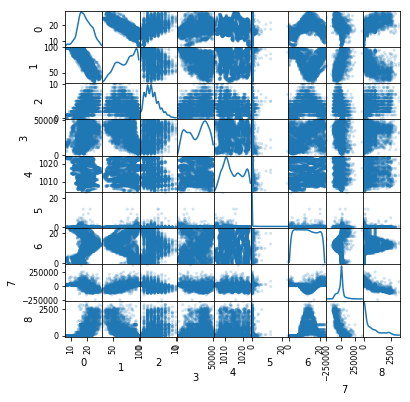

In [219]:
import matplotlib.pyplot as plt
%matplotlib inline

#Merge energy and solar energy produced into feature array
mergedMatrix = np.c_[featureArray,labels,labels_solar]
#Create a pandas dataframe for viz
scatterMatrix = mergedMatrix[:,2:].astype(float)
df = pd.DataFrame(data = scatterMatrix
                  #columns = ['Temp','humidity',
                  #            'wind speed','visibility',
                  #            'rain','Day Hour',
                  #            'net energy','solar']
                 )

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

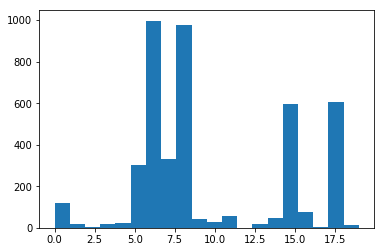

(4276, 13)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0dddb16d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0dd9ed2e8>]], dtype=object)

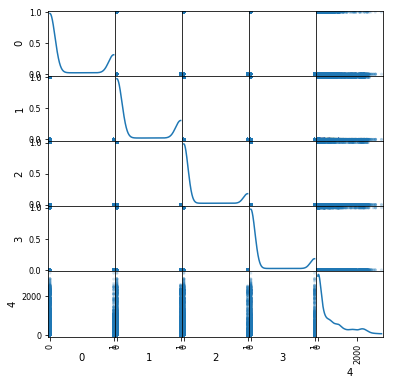

In [220]:
transMatrix = transform_text_labels(featureArray)
merge = np.c_[featureArray,transMatrix]
merge_hot = np.c_[transMatrix,labels_solar]
print(merge.shape)
scatterMatrix = merge_hot.astype(float)
df = pd.DataFrame(data = scatterMatrix)

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')


## Creating a regression model

At this point, we have a clean feature matrix (split into 3 sets) with the corresponding set of labels. Define a helper function to calculate the prediction error for validations and test sets. Define another function that normalizes the feature vector columns. 

Finally use the regression model from scikit-learn to fit training data. Tweak parameters and check their effect by calculating the prediction error for the validation set.

When the best set of parameters are found, check the prediction error on the test-set.

In [241]:
def prediction_error(labels_predict,labels_true):
    """
    Calculates the prediction error as the average absolute difference 
    between predicted and true labels
    
    """
    error = 0
    for predicted,true in zip(labels_predict,labels_true):
        #print('True : {} Predicted : {}'.format(true,predicted))
        error += abs(predicted-true)
    
    error = error/len(labels_predict)
    return error

def normalize_data(data):
    """
    Scales data to [-1,1], to be done before feeding it for regression
    
    """
    scaler = StandardScaler()
    fit = scaler.fit_transform(data)
    return fit

#Split the dataset
data_train,label_train,data_val,label_val,data_test,label_test = split_dataset(featureArray,labels_solar)

# SGD Regression (Don't normalize the one hot encoded labels !)
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
clf = linear_model.SGDRegressor(max_iter = 10**6/X_train.shape[0],
                                tol = 1e-6,
                                alpha = 0.1,
                                )
clf.fit(X_train,labels_train)

print(clf.coef_)
print(clf.score(X_train,labels_train))
print(clf.score(X_val,labels_val))
print(clf.score(X_test,labels_test))



[ 167.04715974 -384.62797079   62.52431519  -55.38440842   50.04871785
   -1.07206054  -70.27895095]
0.620014881285
0.476002141628
0.291565185276


In [250]:
# Ridge Regression
ridge = linear_model.Ridge(alpha=10.0)
ridge.fit(X_train,labels_train)
print(ridge.coef_)
print(ridge.score(X_train,labels_train))

print(ridge.score(X_val,labels_val))
print(ridge.score(X_test,labels_test))


[  75.48088614 -548.42822257   70.80646557 -133.73063899   37.07145715
   -4.68860416  -74.96680866]
0.631833684456
0.463585115402
0.25636773813


In [245]:
# Lasso Regression
lasso = linear_model.Lasso(alpha=10.0)
lasso.fit(X_train,labels_train)
print(lasso.coef_)
print(lasso.score(X_train,labels_train))

print(lasso.score(X_val,labels_val))
print(lasso.score(X_test,labels_test))


[  78.06005508 -525.84431806   57.91664328 -109.63218632   24.76777641
   -0.          -65.25788874]
0.630038756058
0.464485069822
0.268516881078


In [249]:
#Polynomial Features
poly = PolynomialFeatures(degree = 2)
poly_X_train = poly.fit_transform(X_train)
poly_X_val = poly.fit_transform(X_val)
poly_X_test = poly.fit_transform(X_test)

# Lasso Regression
lasso_poly = linear_model.Lasso(alpha=10.0)
lasso_poly.fit(poly_X_train,labels_train)
print(lasso_poly.coef_)
print(lasso_poly.score(poly_X_train,labels_train))

#print(prediction_error(lasso_poly.predict(poly_X_val),labels_val))
#print(prediction_error(lasso_poly.predict(poly_X_test),labels_test))

print(lasso_poly.score(poly_X_val,labels_val))
print(lasso_poly.score(poly_X_test,labels_test))


[  0.00000000e+00   1.22895241e+02  -2.86805859e+02   7.30873434e+00
  -0.00000000e+00   4.90733138e+01  -0.00000000e+00  -7.92359730e+01
   4.99748979e+01  -0.00000000e+00   3.26232243e+01  -2.79934142e+01
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00   1.62410302e+02
  -0.00000000e+00   0.00000000e+00  -6.28850746e+01  -0.00000000e+00
   1.39394242e+02   3.43021475e+01  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00  -1.86240570e+01  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
  -6.82496727e+00  -1.97686011e-01  -0.00000000e+00  -1.52254191e+02]
0.728068600328
0.549333056656
0.401417414515
